In [1]:
%load_ext autoreload
%autoreload 2

In [207]:
from keras.layers import Input, Dense
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from keras_tqdm import TQDMNotebookCallback

In [477]:
import feather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set(style='darkgrid')

In [8]:
# import data

In [9]:
flights = feather.read_dataframe('../data/flights-2008-sample.feather')

In [10]:
# define X, y

In [279]:
X = flights[['DayOfWeek', 'DayofMonth', 'Month', 'ScheduledDepTimestamp', 'Origin', 'Dest', 'UniqueCarrier']].copy()
y = flights['total_delay'].copy()

In [480]:
# encode categorical variables as dummies
# mention that we tried as value counts, but why we decided against

In [281]:
one_hot_matrices = []
for col in filter(lambda col: col != 'ScheduledDepTimestamp', X.columns):
    one_hot_matrices.append( pd.get_dummies(X[col]) )

X = pd.concat(one_hot_matrices, axis=1)

In [282]:
# normalize X columns, log-transform y

In [283]:
X = StandardScaler().fit_transform(X)
y = np.log(y + 1).values

In [284]:
# split into train, validation, test sets

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20000, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=10000, random_state=42)

print('Dataset sizes:')
print('    Train:      {}'.format(X_train.shape))
print('    Validation: {}'.format(X_val.shape))
print('    Test:       {}'.format(X_test.shape))

Dataset sizes:
    Train:      (30000, 654)
    Validation: (10000, 654)
    Test:       (10000, 654)


In [225]:
# build two simple models

## first model

In [286]:
input_dim = X.shape[1]
lr = .001

In [391]:
input_layer = Input((input_dim,), dtype='float32', name='input')
regression_dense = Dense(144, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
regression_output = Dense(1, activation='linear', name='regression_output', kernel_regularizer=l2(0.01))(regression_dense)

is_0_dense = Dense(144, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
is_0_output = Dense(1, activation='sigmoid', name='is_0_output', kernel_regularizer=l2(0.01))(is_0_dense)

In [392]:
model = Model(inputs=[input_layer], outputs=[regression_output, is_0_output])
loss_dict = loss={'regression_output': 'mean_squared_logarithmic_error', 'is_0_output': 'binary_crossentropy'}
loss_weights_dict = {'regression_output': 1., 'is_0_output': 0.5}

model.compile(optimizer=Adam(lr=lr), loss=loss_dict, loss_weights=loss_weights_dict)

In [393]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 654)           0                                            
____________________________________________________________________________________________________
dense_25 (Dense)                 (None, 144)           94320                                        
____________________________________________________________________________________________________
dense_26 (Dense)                 (None, 144)           94320                                        
____________________________________________________________________________________________________
regression_output (Dense)        (None, 1)             145                                          
___________________________________________________________________________________________

In [325]:
model.optimizer.lr.set_value(.01)

In [394]:
network_1 = model.fit(
    x=X_train,
    y=[y_train, y_train == 0],
    batch_size=512, 
    epochs=10,
    validation_data = (X_val, [y_val, y_val == 0]),
    verbose=0,
    callbacks=[TQDMNotebookCallback(leave_outer=False)]
)

In [513]:
def prepare_history_for_plot(history):
    results = pd.DataFrame({
        'train': history.history['loss'],
        'val': history.history['val_loss'],
    })

    results_long = pd.melt(results)
    results_long.columns = ['dataset', 'loss']
    results_long['epoch'] = 2*network_1.epoch
    results_long['subject'] = 1
    return results_long

def plot_training_results(history):
    results = prepare_history_for_plot(history)
    plt.figure(figsize=(11, 7))
    sns.tsplot(data=results, time='epoch', value='loss', condition='dataset', unit='subject')
    plt.title('Training Loss by Epoch', fontsize=13)

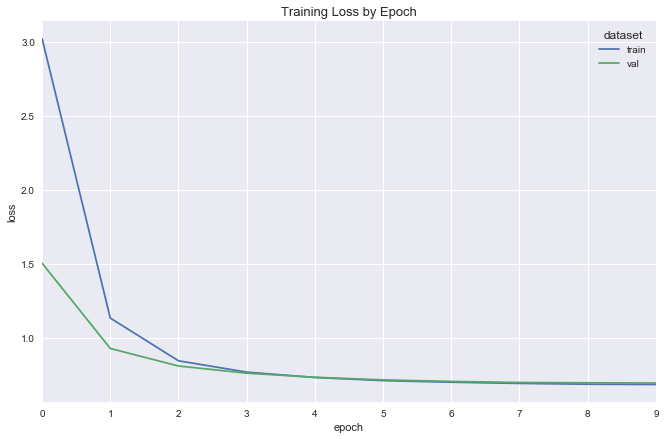

In [514]:
plot_training_results(network_1)